In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [4]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [5]:
print(type(Variable))

<class 'torch.autograd.variable.VariableMeta'>


In [3]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def normalize(image):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image

def predict(image):
    _, index = vgg(image).data[0].max(0)
    return str(index.item()), labels[str(index.item())][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

In [4]:
# proxy
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
vgg = models.vgg16(pretrained=True)

In [5]:
vgg = vgg.cuda()

In [6]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [7]:
modulelist = list(vgg.features.modules())

## CNN Heatmaps : Occlusion

In [8]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        #print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    """
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    """
    
    return heatmap
                    

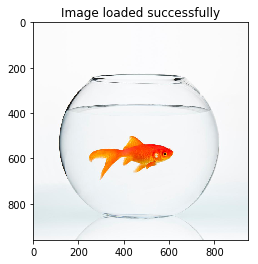

In [9]:
my_img = load_image("images/goldfish.jpg")

In [10]:
my_img = normalize(my_img)

In [11]:
predict(my_img)

('1', 'goldfish')

In [12]:
goldfish_heatmap = make_heatmap(my_img, 1, 16, 8)  # Extremely slow

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


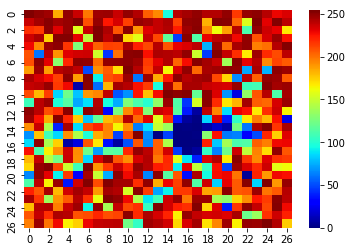

In [13]:
import seaborn as sns
# sns.heatmap(goldfish_heatmap, cmap='jet', square=True, cbar=False)
sns.heatmap(goldfish_heatmap, cmap='jet')

In [14]:
a = vgg(my_img)
# print(a)
temp_softmax = torch.nn.functional.softmax(a)
print(temp_softmax)

tensor([[ 6.1994e-08,  8.5762e-01,  1.4273e-07,  1.4334e-08,  1.2277e-08,
          2.5112e-07,  7.7493e-08,  1.8336e-05,  2.4575e-06,  4.6798e-09,
          9.9760e-08,  4.0418e-07,  1.3622e-06,  3.6534e-07,  3.0389e-08,
          1.0112e-05,  7.4180e-07,  4.3840e-08,  8.1494e-08,  6.2130e-07,
          2.9584e-09,  5.6043e-08,  1.5701e-07,  5.7116e-08,  2.0895e-09,
          9.2931e-08,  4.3137e-08,  2.9224e-06,  1.5913e-07,  7.6108e-07,
          2.3575e-07,  1.0566e-06,  2.0337e-07,  1.6528e-08,  1.5986e-08,
          4.4857e-07,  3.9062e-07,  6.1681e-07,  2.3007e-08,  2.0067e-09,
          2.6348e-07,  2.5213e-09,  1.3447e-08,  3.8275e-07,  5.8947e-09,
          2.3939e-08,  1.1160e-07,  5.4231e-09,  4.4419e-09,  7.6836e-09,
          1.6835e-08,  2.5543e-07,  5.2067e-08,  4.5252e-08,  3.4415e-08,
          4.9726e-09,  1.4990e-07,  1.5022e-09,  1.1036e-06,  1.0242e-07,
          1.3574e-07,  1.0929e-09,  1.8134e-09,  2.2149e-08,  7.1260e-09,
          9.7673e-10,  6.7047e-08,  5.

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
